In [1]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/Users/David/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the data

with np.load('/Users/David/Desktop/EPFL Applied ML/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [3]:
# Rename the data and split into train (3200), test (1000) and validation (800) sets
X_ov = overfeat
X_px = pixels
y = labels

X_ov_tr, X_ov_te, X_px_tr, X_px_te, y_tr, y_te = train_test_split(X_ov, X_px, y, test_size=1000, stratify=y, random_state=0)
X_ov_tr, X_ov_val, X_px_tr, X_px_val, y_tr, y_val = train_test_split(X_ov_tr, X_px_tr, y_tr, test_size=800, stratify=y_tr, random_state=0)

# Double check dimensions for the overfeat data:
print('Train set: {:}'.format(X_ov_tr.shape), 'Test set: {:}'.format(X_ov_te.shape), 'Validation set: {:}'.format(X_ov_val.shape))

Train set: (3200, 4096) Test set: (1000, 4096) Validation set: (800, 4096)


In [4]:
# Transform the data by scaling to improve performance of the gradient descent optimizer

scaler = StandardScaler().fit(X_ov_tr)
X_train_standard = scaler.transform(X_ov_tr)
X_valid_standard = scaler.transform(X_ov_val)
X_test_standard = scaler.transform(X_ov_te)

In [5]:
# Define a function that will be used to select batches of data, using a Python generator

def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [205]:
# Define the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096]) # dimensions set to 4096, as they correspond to the overfeat shape
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    dropout = tf.placeholder(dtype=tf.bool) # placeholder to pass to layers.dropout in order to deactivate some neurons
    alpha = tf.placeholder(dtype=tf.float32) # placeholder to pass as regularization term
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU activation
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0), # initializer for layers with ReLU activation
        bias_initializer=tf.zeros_initializer(), # all zeros initializer
        name='hidden'
    )

    # Apply dropout to hidden layer
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=dropout)
    
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')    
    
    # Output layer with 4 logits
    logits = tf.layers.dense(
        hidden, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0), # initializer for layers without ReLU activation
        bias_initializer=tf.zeros_initializer(), # all zeros initializer
        name='output'
    )

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')
    
    # Loss fuction: mean cross-entropy with regularization term
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits)) # mean cross-entropy
    l2_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W1) # L2 term which includes the hidden and output weight matrices
    loss = mean_ce + alpha * l2_term # total loss with penalization
    
    # Gradient descent parameters
    lr = tf.placeholder(dtype=tf.float32) # learning rate
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr) # gradient descent algorithm

    # Minimize the loss function (cross-entropy with L2 regularization)
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32) # Class with maximum logit
    is_correct = tf.equal(y, predictions) # Compare predictions to target values
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32)) # mean value of correctly predicted logits
    
train_acc_values = [] # empty list to fill with mean training accuracy across batches
valid_acc_values = [] # empty list to fill with validation accuracy

mean_train = [] # empty list to fill with the mean training accuracy for the last 3 epochs
mean_valid = [] # empty list to fill with the mean validation accuracy for the last 3 epochs
epoch_total = [] # empty list to fill with the epoch values
alpha_total = [] # empty list to fill with the regularization strength values
learning_total = [] # empty list to fill with the regularization strength values

learning_rates = [0.1, 0.01, 0.001, 0.0001] #list of learning rates to iterate from. Tested >=1 and always yields 0.25 for both training and validation test
alphas = [0.1, 0.01, 0.001, 0.0001] # list of regularization strengths to iterate from
epochs = [10, 15, 20, 30] # list of epochs to iterate from

with tf.Session(graph=graph) as sess:
    
    # Set seed
    np.random.seed(0)

    # Start nested loops to iterate through the epoch, alphas, and learning rate:
    for learning_value in learning_rates:
        for alpha_value in alphas: 
            for i in np.arange(len(epochs)): 
                epoch_total.append(epochs[i]) # number of epochs
                alpha_total.append(alpha_value) # regularization value
                learning_total.append(learning_value) # learning rates
            
                # Initialize variables - do it inside the parameter loops and before the epochs otherwise it will carry on with the learning from the previous steps
                sess.run(tf.global_variables_initializer())

                for epoch in range(epochs[i]):
                    # Accuracy values (train) after each batch
                    batch_acc = []

                    # Get batches of data of size 64
                    for X_batch, y_batch in get_batches(X_train_standard, y_tr, 64):
                        # Run training and evaluate accuracy
                        _, acc_value = sess.run([train_op, accuracy], feed_dict={
                            X: X_batch,
                            y: y_batch,
                            lr: learning_value, # Learning rate
                            alpha: alpha_value, # Regularization term
                            dropout: True # Apply dropout for the training set
                        })

                        # Save accuracy (current batch)
                        batch_acc.append(acc_value)
                    train_acc_values.append(np.mean(batch_acc))
            
                    # Evaluate validation accuracy
                    valid_acc = sess.run(accuracy, feed_dict={
                        X: X_valid_standard,
                        y: y_val,
                        dropout: False # do not apply dropout because it is the validation set, and we are not fitting anything
                    })
                    valid_acc_values.append(valid_acc)

                # Print progress for the latest value of the epoch - uncheck to allow printing of results
                #print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
                #    epoch+1, valid_acc, np.mean(batch_acc)
                #))   
                
                mean_train.append(np.mean(train_acc_values[-3:])) # save mean values of the 3 last epochs
                mean_valid.append(np.mean(valid_acc_values[-3:]))     
        
    summary = pd.DataFrame({'mean train accuracy': mean_train, # put everything nicely into a dataframe
                            'mean validation accuracy': mean_valid, 
                            'epochs': epoch_total, 
                            'alpha': alpha_total, 
                            'learning rate': learning_total})

In [208]:
summary['delta'] = summary['mean train accuracy'] - summary['mean validation accuracy'] #define a column which is the difference between the train and validation accuracies
summary.sort_values(by=['mean validation accuracy'], ascending=False) 
#summary
# After analyzing the summary results, it seems that the best compromise between a high validation accuracy and a low overfitting of the training set (therefore low delta) is the NN with alpha 0.0001, 20 or 30 epochs and learning rate 0.01

,alpha,epochs,learning rate,mean train accuracy,mean validation accuracy,delta
31,0.0001,30,0.0100,0.921771,0.848333,0.073438
23,0.0100,30,0.0100,0.925729,0.844167,0.081562
30,0.0001,20,0.0100,0.899688,0.843333,0.056354
26,0.0010,20,0.0100,0.895938,0.842083,0.053854
17,0.1000,15,0.0100,0.872188,0.840833,0.031354
18,0.1000,20,0.0100,0.882188,0.839583,0.042604
27,0.0010,30,0.0100,0.927813,0.839167,0.088646
21,0.0100,15,0.0100,0.878750,0.837500,0.041250
19,0.1000,30,0.0100,0.892917,0.836667,0.056250
20,0.0100,10,0.0100,0.854479,0.836667,0.017813


In [220]:
# Rerun the neural network with the tuned values found in the previous step. Epochs are increased to 40 to tune even further the accuracy.

train_acc_values = [] # empty list to fill with mean training accuracy across batches
valid_acc_values = [] # empty list to fill with validation accuracy

mean_train = [] # empty list to fill with the mean training accuracy for the last 3 epochs
mean_valid = [] # empty list to fill with the mean validation accuracy for the last 3 epochs

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)
            
    for epoch in range(40):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data of size 64
        for X_batch, y_batch in get_batches(X_train_standard, y_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01, # Learning rate
                alpha: 0.0001, # Regularization term
                dropout: True # Apply dropout for the training set
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
        train_acc_values.append(np.mean(batch_acc))
            
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_standard,
            y: y_val,
            dropout: False # do not apply dropout because it is the validation set, and we are not fitting anything
        })
        valid_acc_values.append(valid_acc)

        # Print progress for the epochs
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))   
        
    mean_train.append(np.mean(train_acc_values[-3:])) # save mean values of the 3 last epochs
    mean_valid.append(np.mean(valid_acc_values[-3:]))     
        
    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()
    biases_hidden = b1.eval()
    biases_output = b2.eval()
    
    # Test accuracy
    test_acc_val = sess.run(accuracy, feed_dict={
        X: X_test_standard, # Rescaled data
        y: y_te,
        W1: weights_hidden, # Set hidden weights
        b1: biases_hidden, # Set hidden biases
        W2: weights_output, # Set output weights
        b2: biases_output, # Set output biases
        dropout: False # do not apply dropout because it is the test set, and we are not fitting anything
    })
    print('Multilayer fully-connected network accuracy (test set): {:.3f}'.format(test_acc_val))
    
# Mean train and validation accuracies for the last 3 epochs might be a bit different (yet close enough) from the ones in the summary dataframe - this is due to the stochastic nature of the optimization algorithm. 

Epoch 1 - valid: 0.776 train: 0.625 (mean)
Epoch 2 - valid: 0.798 train: 0.757 (mean)
Epoch 3 - valid: 0.815 train: 0.797 (mean)
Epoch 4 - valid: 0.819 train: 0.813 (mean)
Epoch 5 - valid: 0.816 train: 0.823 (mean)
Epoch 6 - valid: 0.812 train: 0.833 (mean)
Epoch 7 - valid: 0.821 train: 0.846 (mean)
Epoch 8 - valid: 0.817 train: 0.854 (mean)
Epoch 9 - valid: 0.825 train: 0.848 (mean)
Epoch 10 - valid: 0.822 train: 0.854 (mean)
Epoch 11 - valid: 0.834 train: 0.867 (mean)
Epoch 12 - valid: 0.837 train: 0.870 (mean)
Epoch 13 - valid: 0.831 train: 0.872 (mean)
Epoch 14 - valid: 0.835 train: 0.877 (mean)
Epoch 15 - valid: 0.840 train: 0.877 (mean)
Epoch 16 - valid: 0.842 train: 0.887 (mean)
Epoch 17 - valid: 0.841 train: 0.885 (mean)
Epoch 18 - valid: 0.839 train: 0.898 (mean)
Epoch 19 - valid: 0.837 train: 0.903 (mean)
Epoch 20 - valid: 0.845 train: 0.897 (mean)
Epoch 21 - valid: 0.839 train: 0.901 (mean)
Epoch 22 - valid: 0.840 train: 0.903 (mean)
Epoch 23 - valid: 0.841 train: 0.905 (mea

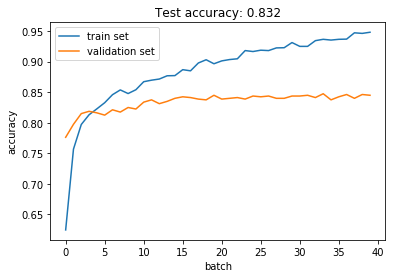

In [223]:
# Plot the results for training and validation for the tuned parameters

%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(train_acc_values, label='train set')
plt.plot(valid_acc_values, label='validation set')
plt.title('Test accuracy: {:.3f}'.format(
    test_acc_val
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()